In [2]:
import jax
import jax.numpy as jnp
import networkx as nx
from typing import NamedTuple

In [3]:
class Node(NamedTuple):
    index: jnp.int32
    type: jnp.int32
    enabled: jnp.bool_


class ActivationState(NamedTuple):
    activations: jnp.ndarray
    activated_nodes: jnp.ndarray
    activation_counts: jnp.ndarray


class Network(NamedTuple):
    nodes: list[Node]
    edges: jnp.ndarray
    senders: jnp.ndarray
    receivers: jnp.ndarray

    @property
    def n_nodes(self) -> int:
        return len(self.nodes.index)

    @property
    def input_nodes(self) -> int:
        return jnp.where(self.nodes.type == 1)[0]

    @property
    def n_inputs(self) -> int:
        return len(self.input_nodes)

    @property
    def n_required_activations(self) -> dict:
        """
        The number of required activations for each receiver node.
        """
        unique, counts = jnp.unique(self.receivers, return_counts=True)
        return jnp.zeros(self.n_nodes).at[unique].set(counts)


def init_activations(
    net: Network, inputs: jnp.ndarray
) -> tuple[jnp.ndarray, jnp.ndarray]:
    activations = jnp.zeros(net.n_nodes).at[: net.n_inputs].set(inputs)
    activated_nodes = jnp.int32(activations > 0)
    return activations, activated_nodes

In [4]:
def plot_network(net: Network) -> None:
    def convert_jraph_to_networkx_graph(net: Network) -> nx.Graph:
        n_nodes = len(net.nodes)
        n_edges = len(net.edges)

        nx_graph = nx.DiGraph()
        if net.nodes is None:
            for n in range(n_nodes[0]):
                nx_graph.add_node(n)
        else:
            for n in range(n_nodes):
                nx_graph.add_node(n, node_feature=net.nodes[n])
        if net.edges is None:
            for e in range(n_edges):
                nx_graph.add_edge(int(net.senders[e]), int(net.receivers[e]))
        else:
            for e in range(n_edges):
                nx_graph.add_edge(
                    int(net.senders[e]),
                    int(net.receivers[e]),
                    edge_feature=net.edges[e],
                )
        return nx_graph

    nx_graph = convert_jraph_to_networkx_graph(net)
    pos = nx.spring_layout(nx_graph)
    nx.draw(nx_graph, pos=pos, with_labels=True, node_size=500, font_color="yellow")

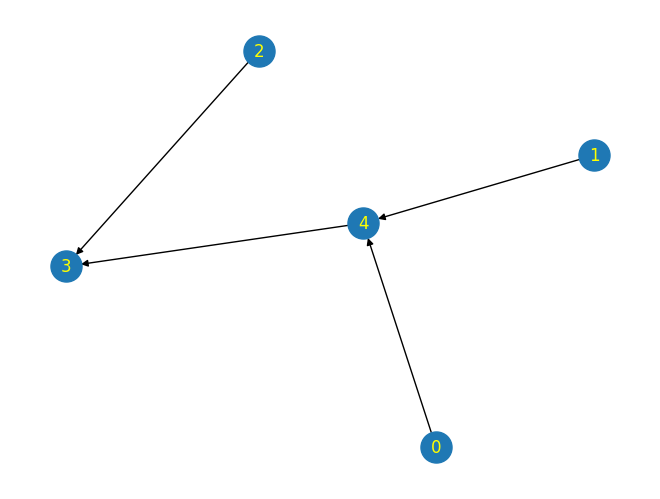

In [5]:
n_nodes = 5
nodes = jax.vmap(Node)(
    index=jnp.arange(n_nodes),
    type=jnp.array([1, 1, 1, 3, 2]),
    enabled=jnp.ones(n_nodes),
)
net = Network(
    nodes,
    edges=jnp.ones(n_nodes - 1),
    senders=jnp.array([0, 1, 2, 4]),
    receivers=jnp.array([4, 4, 3, 3]),
)
plot_network(net)

In [6]:
def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

In [7]:
def add_activations(
    senders: jnp.ndarray,
    receivers: jnp.ndarray,
    activation_state: ActivationState,
) -> ActivationState:
    """
    For given sender nodes, iteratively computes the activation
    of receiver nodes while carrying the global activation state.
    """

    def add_single_activation(activation_state: jnp.ndarray, x: tuple) -> jnp.ndarray:
        senders, receivers = x
        activations = activation_state.activations
        activation_counts = activation_state.activation_counts

        activations = activations.at[receivers].add(activations[senders])
        activation_counts = activation_counts.at[receivers].add(1)
        return (
            activation_state._replace(
                activations=activations,
                activation_counts=activation_counts,
            ),
            None,
        )

    activation_state, _ = jax.lax.scan(
        add_single_activation,
        activation_state,
        jnp.stack((senders, receivers), axis=1),
    )
    return activation_state

In [8]:
def get_receivers(net: Network, senders: int) -> jnp.ndarray:
    """
    Returns the receiver nodes indices for a given list of senders.
    """
    return jax.tree_map(lambda s: net.receivers[s], senders)

In [9]:
def update_activated_neurons(
    net: Network,
    senders: jnp.ndarray,
    receivers: jnp.ndarray,
    activation_state: ActivationState,
) -> ActivationState:

    def toggle_receivers(
        net: Network,
        receivers: jnp.ndarray,
        activation_state: ActivationState,
    ) -> jnp.ndarray:

        def is_activated(
            net: Network, index: int, activation_counts: jnp.ndarray
        ) -> jnp.int32:
            return jnp.int32(
                net.n_required_activations[index] == activation_counts[index]
            )

        unique_receivers = jnp.unique(receivers)
        toggle_nodes = jax.vmap(is_activated, in_axes=(None, 0, None))(
            net, unique_receivers, activation_state.activation_counts
        )

        # TODO: add sigmoid
        return activation_state.activated_nodes.at[unique_receivers].set(toggle_nodes)

    def deactivate_past_senders(
        activations: jnp.ndarray, nodes_indices: jnp.ndarray
    ) -> jnp.ndarray:
        return activations.at[nodes_indices].set(0)

    activated_nodes = toggle_receivers(net, receivers, activation_state)
    activated_nodes = deactivate_past_senders(activated_nodes, senders)

    done = jnp.all(
        jax.tree_map(
            lambda a, b: a == b,
            activation_state.activation_counts,
            net.n_required_activations,
        )
    )

    activated_nodes = jax.lax.select(
        done,
        jnp.zeros(net.n_nodes, dtype=jnp.int32),
        activated_nodes,
    )

    return activation_state._replace(activated_nodes=activated_nodes)

In [10]:
inputs = jnp.array([0.5, 0.8, 0.2])
activations, activated_nodes = init_activations(net, inputs)
activation_counts = jnp.zeros(net.n_nodes)

activation_state = ActivationState(activations, activated_nodes, activation_counts)

senders = net.input_nodes
receivers = get_receivers(net, senders)

while activation_state.activated_nodes.sum() > 0 :
    activation_state = add_activations(senders, receivers, activation_state)
    activation_state = update_activated_neurons(net, senders, receivers, activation_state)
    senders = jnp.nonzero(activation_state.activated_nodes)[0]
    receivers = get_receivers(net, senders)
    print(jax.tree_map(lambda x: print(f"{x=}"), activation_state))
    print(senders, receivers)

x=Array([0.5, 0.8, 0.2, 0.2, 1.3], dtype=float32)
x=Array([0, 0, 0, 0, 1], dtype=int32)
x=Array([0., 0., 0., 1., 2.], dtype=float32)
ActivationState(activations=None, activated_nodes=None, activation_counts=None)
[4] [3]
x=Array([0.5, 0.8, 0.2, 1.5, 1.3], dtype=float32)
x=Array([0, 0, 0, 0, 0], dtype=int32)
x=Array([0., 0., 0., 2., 2.], dtype=float32)
ActivationState(activations=None, activated_nodes=None, activation_counts=None)
[] []


```python
def while_loop(cond_fun, body_fun, init_val):
  val = init_val
  while cond_fun(val):
    val = body_fun(val)
  return val
```

In [11]:
inputs = jnp.array([0.5, 0.8, 0.2])
activations, activated_nodes = init_activations(net, inputs)
activation_counts = jnp.zeros(net.n_nodes)

activation_state = ActivationState(activations, activated_nodes, activation_counts)

senders = net.input_nodes
receivers = get_receivers(net, senders)


def check_termination(val: tuple) -> bool:
    activation_state, _, _  = val
    return activation_state.activated_nodes.sum() > 0

def body_fn(val: tuple) -> tuple:
    activation_state, senders, receivers = val

    activation_state = add_activations(senders, receivers, activation_state)
    activation_state = update_activated_neurons(net, senders, receivers, activation_state)
    senders = jnp.nonzero(activation_state.activated_nodes)[0]
    receivers = get_receivers(net, senders)

    return (activation_state, senders, receivers)


jax.lax.while_loop(check_termination, body_fn, (activation_state, senders, receivers))

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape int32[3].
The error arose for the first argument of jnp.unique(). To make jnp.unique() compatible with JIT and other transforms, you can specify a concrete value for the size argument, which will determine the output size.
The error occurred while tracing the function body_fn at C:\Users\ryanp\AppData\Local\Temp\ipykernel_32084\886975513.py:15 for while_loop. This concrete value was not available in Python because it depends on the value of the argument val[2].

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError